In [1]:
%%time
import os
import json
import warnings
from math import sqrt

import ipfshttpclient
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from web3 import Web3
from keras import metrics
from keras.layers import GRU, Input, RepeatVector, concatenate, Activation, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pandas import read_csv
from numpy import split, array
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError

warnings.filterwarnings("ignore")

CPU times: total: 641 ms
Wall time: 6.11 s


In [2]:
%%time
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8573"))
print(w3.is_connected())
w3.eth.default_account=w3.eth.accounts[0]

True
CPU times: total: 0 ns
Wall time: 37.5 ms


In [3]:
%%time
abi1=[
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "modelCount",
				"type": "uint256"
			},
			{
				"internalType": "string",
				"name": "_modelData1",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "_modelData2",
				"type": "string"
			}
		],
		"name": "setModelData",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "dataCount",
				"type": "uint256"
			},
			{
				"internalType": "string",
				"name": "_data1",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "_data2",
				"type": "string"
			}
		],
		"name": "setTrainingData",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "accessListAddress",
				"type": "address"
			}
		],
		"stateMutability": "nonpayable",
		"type": "constructor"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "modelCount",
				"type": "uint256"
			},
			{
				"internalType": "string",
				"name": "_modelData1",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "_modelData2",
				"type": "string"
			}
		],
		"name": "updateModelData",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "dataCount",
				"type": "uint256"
			},
			{
				"internalType": "string",
				"name": "_data1",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "_data2",
				"type": "string"
			}
		],
		"name": "updateTrainingData",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "",
				"type": "uint256"
			}
		],
		"name": "dataMap",
		"outputs": [
			{
				"internalType": "string",
				"name": "data1",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "data2",
				"type": "string"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "index",
				"type": "uint256"
			}
		],
		"name": "getModelData",
		"outputs": [
			{
				"components": [
					{
						"internalType": "string",
						"name": "modelData1",
						"type": "string"
					},
					{
						"internalType": "string",
						"name": "modelData2",
						"type": "string"
					}
				],
				"internalType": "struct Publish.ModelData",
				"name": "",
				"type": "tuple"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "getNodeAddress",
				"type": "address"
			}
		],
		"name": "getNodeInfo",
		"outputs": [
			{
				"internalType": "bool",
				"name": "",
				"type": "bool"
			},
			{
				"internalType": "uint8",
				"name": "",
				"type": "uint8"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "index",
				"type": "uint256"
			}
		],
		"name": "getTrainingData",
		"outputs": [
			{
				"components": [
					{
						"internalType": "string",
						"name": "data1",
						"type": "string"
					},
					{
						"internalType": "string",
						"name": "data2",
						"type": "string"
					}
				],
				"internalType": "struct Publish.TrainingData",
				"name": "",
				"type": "tuple"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "",
				"type": "uint256"
			}
		],
		"name": "modelMap",
		"outputs": [
			{
				"internalType": "string",
				"name": "modelData1",
				"type": "string"
			},
			{
				"internalType": "string",
				"name": "modelData2",
				"type": "string"
			}
		],
		"stateMutability": "view",
		"type": "function"
	}
]


CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
address1 = "0x6041cc1c53F338281FB623b409Ebd90e40557f71"
Pub_contract = w3.eth.contract(address=address1, abi=abi1)

CPU times: total: 0 ns
Wall time: 9.09 ms


In [5]:
%%time
abi=[
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "accessListAddress",
				"type": "address"
			}
		],
		"stateMutability": "nonpayable",
		"type": "constructor"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "index",
				"type": "uint256"
			}
		],
		"name": "change_train_status",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [],
		"name": "configsCount",
		"outputs": [
			{
				"internalType": "uint256",
				"name": "",
				"type": "uint256"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "index",
				"type": "uint256"
			}
		],
		"name": "deleteConfiguration",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "index",
				"type": "uint256"
			}
		],
		"name": "getConfiguration",
		"outputs": [
			{
				"components": [
					{
						"internalType": "uint256",
						"name": "n_past",
						"type": "uint256"
					},
					{
						"internalType": "uint256",
						"name": "n_features",
						"type": "uint256"
					},
					{
						"internalType": "uint256",
						"name": "n_future",
						"type": "uint256"
					},
					{
						"internalType": "uint256",
						"name": "lstm_units_1",
						"type": "uint256"
					},
					{
						"internalType": "uint256",
						"name": "lstm_units_2",
						"type": "uint256"
					},
					{
						"internalType": "uint256",
						"name": "dense_units_1",
						"type": "uint256"
					},
					{
						"internalType": "uint256",
						"name": "dense_units_2",
						"type": "uint256"
					},
					{
						"internalType": "bool",
						"name": "train",
						"type": "bool"
					}
				],
				"internalType": "struct Config_Data.Configuration",
				"name": "",
				"type": "tuple"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "getNodeAddress",
				"type": "address"
			}
		],
		"name": "getNodeInfo",
		"outputs": [
			{
				"internalType": "bool",
				"name": "",
				"type": "bool"
			},
			{
				"internalType": "uint8",
				"name": "",
				"type": "uint8"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "",
				"type": "uint256"
			}
		],
		"name": "modelConfigs",
		"outputs": [
			{
				"internalType": "uint256",
				"name": "n_past",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "n_features",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "n_future",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "lstm_units_1",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "lstm_units_2",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "dense_units_1",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "dense_units_2",
				"type": "uint256"
			},
			{
				"internalType": "bool",
				"name": "train",
				"type": "bool"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "_configsCount",
				"type": "uint256"
			},
			{
				"internalType": "bool",
				"name": "_train",
				"type": "bool"
			},
			{
				"internalType": "uint256",
				"name": "_n_past",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_n_features",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_n_future",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_lstm_units_1",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_lstm_units_2",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_dense_units_1",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_dense_units_2",
				"type": "uint256"
			}
		],
		"name": "setConfiguration",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "uint256",
				"name": "index",
				"type": "uint256"
			},
			{
				"internalType": "bool",
				"name": "_train",
				"type": "bool"
			},
			{
				"internalType": "uint256",
				"name": "_n_past",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_n_features",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_n_future",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_lstm_units_1",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_lstm_units_2",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_dense_units_1",
				"type": "uint256"
			},
			{
				"internalType": "uint256",
				"name": "_dense_units_2",
				"type": "uint256"
			}
		],
		"name": "updateConfiguration",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	}
]
address = "0x3F2948E1faCc1F5B394eeb0D61B83A5fF07aaEcc"
Conf_contract = w3.eth.contract(address=address, abi=abi)

CPU times: total: 0 ns
Wall time: 10.7 ms


In [6]:
%%time
# Connect to IPFS
client = ipfshttpclient.connect("/ip4/127.0.0.1/tcp/5001/http")

CPU times: total: 15.6 ms
Wall time: 66.2 ms


In [7]:
%%time
H_u=Pub_contract.functions.getModelData(3).call()

CPU times: total: 15.6 ms
Wall time: 10.9 ms


In [8]:
H_u[1]

'QmWjexmYjgNVsiVU3jfE3f2vcTRBfkE5553QXnpxg4eKA7'

In [9]:
#C=Conf_contract.functions.getConfiguration(1).call()

In [10]:
%%time
n_past=30
n_features=14
n_future=20

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
df1 = pd.read_csv('unit16.csv', header=0,index_col=0)
df=df1.iloc[0:100000,:]

CPU times: total: 1.91 s
Wall time: 7.97 s


In [12]:
%%time
df=df.fillna(0)
df = df.iloc[:, :-4]

CPU times: total: 15.6 ms
Wall time: 21.4 ms


In [13]:
df = df[['T24', 'T30', 'T48', 'T50', 'P15', 'P21',
         'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf','RUL']]
df.shape

(100000, 14)

In [14]:
%%time
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

CPU times: total: 0 ns
Wall time: 14.7 ms


In [15]:
scaled

array([[0.95859311, 0.98330029, 0.9887222 , ..., 0.98382793, 0.99184762,
        1.        ],
       [0.95929772, 0.98328789, 0.9871369 , ..., 0.98407752, 0.99043273,
        1.        ],
       [0.95897487, 0.98298709, 0.98718425, ..., 0.98372936, 0.99012479,
        1.        ],
       ...,
       [0.65087609, 0.76560298, 0.81522938, ..., 0.77715335, 0.55926689,
        0.        ],
       [0.6504374 , 0.76524561, 0.81495846, ..., 0.77681709, 0.55894492,
        0.        ],
       [0.65120601, 0.76565424, 0.81587483, ..., 0.77709071, 0.55962946,
        0.        ]])

In [16]:
%%time
# Prepare the input and target data
def create_dataset(data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i])
        y.append(data[i:i + n_future, -1])
    return np.array(X), np.array(y)



X, y = create_dataset(scaled, n_past, n_future)


CPU times: total: 203 ms
Wall time: 375 ms


In [17]:
X.shape,y.shape

((99951, 30, 14), (99951, 20))

In [18]:
%%time
# Get hashes
model_json_hash_u = H_u[0]
model_h5_hash_u = H_u[1]


CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
import os

# Define the directory where you want to save the model and weights
save_dir = "C:\\Users\\montd\Desktop\\Project\\Deep Learning\\2\\Updatable2"

In [20]:
%%time
# Retrieve the files from IPFS
model_json_file_u = client.cat(model_json_hash_u)
model_h5_file_u = client.cat(model_h5_hash_u)

CPU times: total: 0 ns
Wall time: 13.5 ms


In [21]:
%%time
# Save the retrieved model architecture
with open(os.path.join(save_dir, 'retrieved_model_u.json'), 'w') as file:
    file.write(model_json_file_u.decode('utf-8'))

# Save the retrieved model weights
with open(os.path.join(save_dir, 'retrieved_model_u.h5'), 'wb') as file:
    file.write(model_h5_file_u)

# Load the model architecture
with open(os.path.join(save_dir, 'retrieved_model_u.json'), 'r') as file:
    loaded_model_json = file.read()

# Create a model from the loaded architecture
loaded_model_u = model_from_json(loaded_model_json)

# Load the weights into the model
loaded_model_u.load_weights(os.path.join(save_dir, 'retrieved_model_u.h5'))

CPU times: total: 141 ms
Wall time: 1.1 s


In [22]:
loaded_model_u.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              30720     
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 20, 128)          0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 1)            129       
 ibuted)                                                         
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
predictions_u = loaded_model_u.predict(X)

3124/3124 [==============================] - 15s 4ms/step
CPU times: total: 17.5 s
Wall time: 19.4 s


In [24]:
%%time
predictions_u = np.squeeze(predictions_u)
np.shape(predictions_u)

CPU times: total: 0 ns
Wall time: 0 ns


(99951, 20)

In [26]:
%%time
H_l=Pub_contract.functions.getModelData(4).call()




CPU times: total: 0 ns
Wall time: 9.03 ms


In [27]:
%%time
# Get hashes
model_json_hash_l = H_l[0]
model_h5_hash_l = H_l[1]

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
%%time
# Retrieve files from IPFS
model_json_file_l = client.cat(model_json_hash_l)
model_h5_file_l = client.cat(model_h5_hash_l)

CPU times: total: 0 ns
Wall time: 35 ms


In [29]:
%%time
# Save files locally
with open('retrieved_model.json', 'w') as file:
    file.write(model_json_file_l.decode('utf-8'))

with open('retrieved_model.h5', 'wb') as file:
    file.write(model_h5_file_l)

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [30]:
%%time
import keras 
# Load model architecture from JSON
with open('retrieved_model.json', 'r') as json_file:
    loaded_model_json_l = json_file.read()

loaded_model_l = keras.models.model_from_json(loaded_model_json_l)

# Load weights into the model
loaded_model_l.load_weights("retrieved_model.h5")

CPU times: total: 141 ms
Wall time: 984 ms


In [31]:
loaded_model_l.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              30720     
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 20, 128)          0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 1)            129       
 ibuted)                                                         
                                                                 
Total params: 30,849
Trainable params: 30,849
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
predictions_l = loaded_model_l.predict(X)

3124/3124 [==============================] - 15s 4ms/step
CPU times: total: 14.2 s
Wall time: 18 s


In [33]:
%%time
predictions_l = np.squeeze(predictions_l)
np.shape(predictions_l)

CPU times: total: 0 ns
Wall time: 0 ns


(99951, 20)

In [34]:

np.shape(y)


(99951, 20)

In [35]:
mae = mean_absolute_error(y, predictions_u)
mse = mean_squared_error(y, predictions_u)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.0008919429106382587
Mean Squared Error: 1.5671153440104362e-05
Root Mean Squared Error: 0.003958680770168815


In [36]:
mae = mean_absolute_error(y, predictions_l)
mse = mean_squared_error(y, predictions_l)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.0008304708014232889
Mean Squared Error: 1.554198813288116e-05
Root Mean Squared Error: 0.003942332828780589


In [38]:
%%time
c = 0.8
d = 0.2
weighted_avg = c*predictions_l + d*predictions_u

CPU times: total: 0 ns
Wall time: 7.69 ms


In [39]:
np.shape(weighted_avg)

(99951, 20)

In [40]:
mae = mean_absolute_error(y, weighted_avg)
mse = mean_squared_error(y, weighted_avg)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.000842237429262744
Mean Squared Error: 1.5560335883794207e-05
Root Mean Squared Error: 0.00394465915939441


In [41]:
good_predictions = []
good_actual_values = []
good_indices = []
threshold = 0.05  # Define your own threshold

for i in range(len(weighted_avg)):
    if (np.abs(weighted_avg[i] - y[i]) <= threshold).all():
        good_predictions.append(weighted_avg[i])
        good_actual_values.append(y[i])
        good_indices.append(i)

all_indices = set(range(len(weighted_avg)))
bad_indices = list(all_indices - set(good_indices))

# Delete the bad indices from the input_data
X = np.delete(X, np.array(list(bad_indices)), axis=0)

In [42]:
np.shape(X),np.shape(good_predictions)

((99811, 30, 14), (99811, 20))

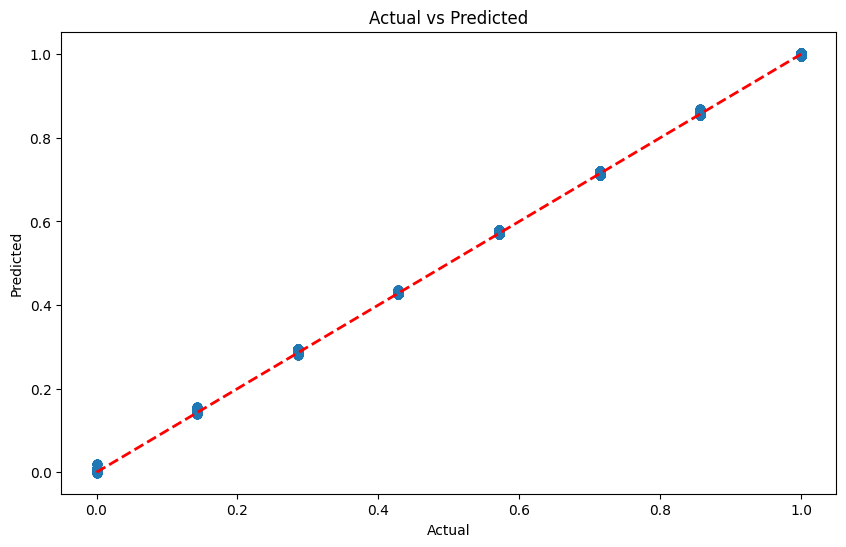

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(good_actual_values, good_predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [44]:
type(X)

numpy.ndarray

In [45]:
%%time
# Convert numpy arrays to lists
x_list = X.tolist()
#y_list = good_predictions.tolist()

CPU times: total: 1.75 s
Wall time: 8.26 s


In [46]:
type(x_list)

list

In [47]:
%%time
# Combine into one dictionary
data2 = {'x': x_list, 'y': [pred.tolist() for pred in good_predictions]}
# Write to JSON file
with open('data2.json', 'w') as f:
    json.dump(data2, f)

CPU times: total: 44.9 s
Wall time: 1min 41s


In [48]:
%%time
# Add file to IPFS
res2 = client.add('data2.json')
print(res2)

<ipfshttpclient.client.base.ResponseBase: {'Name': 'data2.json', 'Hash': 'QmXe4J5uAzPNY3utHQv4xN7WExTimUcmZ39PEtoZocpFw5', 'Size': '890852372'}>
CPU times: total: 2.39 s
Wall time: 4.41 s


In [49]:
%%time
Pub_contract.functions.setTrainingData(3,res2['Hash'],res2['Hash']).transact()

CPU times: total: 0 ns
Wall time: 24.8 ms


HexBytes('0x37dedf30b8914b262634e8bec21c12e006ea6b5ea2086b482977aac3bfa9665a')